In [1]:
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd

In [2]:
TAG = "ECG200"

In [3]:
ts = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
results_folder = f'./results/{TAG}/{ts}'
os.makedirs(results_folder, exist_ok=True)

In [4]:
!which pip

/home/samir/miniconda3/envs/gendis/bin/pip


In [5]:
!pip freeze | grep GENDIS

GENDIS==1.0.13


In [6]:
from gendis.genetic import GeneticExtractor
from gendis.fitness import SubgroupDistance

In except import


/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
error_df = pd.read_csv(f'data/{TAG}/{TAG}_processed_error.csv')

In [8]:
error_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,truth,clf_pred,clf_prob,error
0,1.088076,1.564040,1.368890,1.250157,1.491498,1.682589,1.226951,0.343969,-0.335317,-0.729320,...,2.150796,2.385066,1.993872,1.760286,1.269218,0.399103,0,0,0.096398,0.096398
1,0.955804,1.603964,2.728597,4.147563,2.942624,1.382093,0.037531,-0.339903,0.465481,0.797179,...,-0.137032,-0.510956,-0.414687,-0.289843,-0.471944,-0.345898,1,1,0.970263,0.029737
2,1.709221,2.752852,1.682990,1.241862,-0.037972,-0.217589,0.789646,0.547428,0.302104,0.339065,...,0.111021,0.308668,0.048724,0.072167,0.348025,0.658488,1,1,0.986109,0.013891


In [9]:
X = error_df.drop(columns=['truth', 'clf_pred', 'clf_prob', 'error'])
y = error_df['error']

# Sampling
# X = X.sample(n=400)
# y = y[X.index]

In [10]:
y.describe()

count    100.000000
mean       0.196339
std        0.249543
min        0.000283
25%        0.023708
50%        0.078806
75%        0.284824
max        0.912535
Name: error, dtype: float64

In [11]:
help(GeneticExtractor)

Help on class GeneticExtractor in module gendis.genetic:

class GeneticExtractor(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Feature selection with genetic algorithm.
 |  
 |  Parameters
 |  ----------
 |  population_size : int
 |      The number of individuals in our population. Increasing this parameter
 |      increases both the runtime per generation, as the probability of
 |      finding a good solution.
 |  
 |  iterations : int
 |      The maximum number of generations the algorithm may run.
 |  
 |  wait : int
 |      If no improvement has been found for `wait` iterations, then stop
 |  
 |  add_noise_prob : float
 |      The chance that gaussian noise is added to a random shapelet from a
 |      random individual every generation
 |  
 |  add_shapelet_prob : float
 |      The chance that a shapelet is added to a random shapelet set every gen
 |  
 |  remove_shapelet_prob : float
 |      The chance that a shapelet is deleted to a random shap set every gen
 | 

In [12]:
DIST_THRESHOLD = 0.5

fitness_func = SubgroupDistance(
    distance_function=SubgroupDistance.wasserstein_distance, 
    shapelet_dist_threshold=DIST_THRESHOLD
)

args = {
    "fitness": fitness_func,
    "population_size": 50, 
    "iterations": 50,  
    "mutation_prob": 0.3, 
    "crossover_prob": 0.3,
    "max_shaps": 5,
    "wait": 20, 
    "max_len": 35,
    "n_jobs": multiprocessing.cpu_count() - 1,
    "verbose": True,
    "dist_threshold": DIST_THRESHOLD,
} 

gendis = GeneticExtractor(**args)

In [13]:
gendis.__dict__

{'population_size': 50,
 'iterations': 50,
 'verbose': True,
 'mutation_prob': 0.3,
 'crossover_prob': 0.3,
 'plot': None,
 'wait': 20,
 'n_jobs': 15,
 'normed': False,
 '_min_length': 0,
 'max_len': 35,
 'max_shaps': 5,
 'init_ops': [<function gendis.operators.random_shapelet(X, n_shapelets, min_len, max_len)>,
  <function gendis.operators.kmeans(X, n_shapelets, min_len, max_len, n_draw=None)>],
 'cx_ops': [<function gendis.operators.merge_crossover(ind1, ind2, p=0.25)>,
  <function gendis.operators.point_crossover(ind1, ind2)>,
  <function gendis.operators.shap_point_crossover(ind1, ind2, p=0.25)>],
 'mut_ops': [<function gendis.operators.add_shapelet(shapelets, toolbox)>,
  <function gendis.operators.remove_shapelet(shapelets, toolbox)>,
  <function gendis.operators.mask_shapelet(shapelets, toolbox)>],
 'is_fitted': False,
 'dist_threshold': 0.5,
 'fitness': <gendis.fitness.SubgroupDistance at 0x7f4db78b99e8>,
 'label_mapping': {},
 'shapelets': []}

In [14]:
%%time
gendis.fit(X, y.values)

it		avg		std		max		time
1		0.0164		0.036		0.129359	0.5565
2		0.0639		0.065		0.225371	0.5057
3		0.1028		0.062		0.225371	0.5068
4		0.1106		0.05		0.225371	0.6055
5		0.17		0.06		0.253185	0.5843
6		0.1778		0.061		0.253185	0.4701
7		0.1803		0.074		0.292171	0.5263
8		0.1988		0.088		0.376093	0.4944
9		0.2144		0.085		0.376093	0.5018
10		0.2589		0.07		0.376093	0.5077
11		0.2265		0.074		0.376093	0.5243
12		0.2405		0.061		0.376093	0.5057
13		0.2497		0.055		0.376093	0.497
14		0.2459		0.07		0.376093	0.6212
15		0.2288		0.096		0.376093	0.6449
16		0.2615		0.083		0.376093	0.5985
17		0.2863		0.071		0.376093	0.6202
18		0.3135		0.056		0.376093	0.6219
19		0.3121		0.059		0.376093	0.6282
20		0.3182		0.044		0.376093	0.6356
21		0.3012		0.06		0.376093	0.6342
22		0.2986		0.061		0.376093	0.6261
23		0.3081		0.067		0.391685	0.6958
24		0.2457		0.104		0.391685	0.5775
25		0.2133		0.116		0.391685	0.6111
26		0.2345		0.114		0.391685	0.5734
27		0.2818		0.091		0.391685	0.6507
28		0.2975		0.06		0.391685	0.6068
29		0.3084		0.

In [15]:
gendis.save(f'{results_folder}/gendis.pickle')

In [16]:
gendis.best

{'it': 23,
 'score': 0.3916854620999453,
 'info': {'dist': 0.45050899151171003,
  'subgroup_error_mean': 0.5698607151515738,
  'rest_error_mean': 0.11983428666635657,
  'subgroup_size': 17},
 'shapelets': [array([-0.4564117 , -0.29351677, -0.04833457,  0.1432135 ,  0.2684479 ,
          0.37448588,  0.43712032,  0.52029813,  0.64595463]),
  array([-1.23063369, -1.06064826, -0.95890874, -0.83511705, -0.50142272,
         -0.35630359]),
  array([0.54178887, 0.52360493, 0.3974649 , 0.37124313, 0.49892224,
         0.58663415, 0.5973956 , 0.63001226])]}

In [17]:
gendis.top_10_best

[{'score': 0.3916854620999453,
  'info': {'dist': 0.45050899151171003,
   'subgroup_error_mean': 0.5698607151515738,
   'rest_error_mean': 0.11983428666635657,
   'subgroup_size': 17},
  'shapelets': [array([-0.8435227 , -0.67708251, -0.50362165, -0.34595177, -0.11648741,
           0.00909114]),
   array([-0.4564117 , -0.29351677, -0.04833457,  0.1432135 ,  0.2684479 ,
           0.37448588,  0.43712032,  0.52029813,  0.64595463]),
   array([0.54178887, 0.52360493, 0.3974649 , 0.37124313, 0.49892224,
          0.58663415, 0.5973956 , 0.63001226])]},
 {'score': 0.3916854620999453,
  'info': {'dist': 0.45050899151171003,
   'subgroup_error_mean': 0.5698607151515738,
   'rest_error_mean': 0.11983428666635657,
   'subgroup_size': 17},
  'shapelets': [array([-0.8435227 , -0.67708251, -0.50362165, -0.34595177, -0.11648741,
           0.00909114]),
   array([-0.4564117 , -0.29351677, -0.04833457,  0.1432135 ,  0.2684479 ,
           0.37448588,  0.43712032,  0.52029813,  0.64595463]),
   arr

In [18]:
shapelets = gendis.best["shapelets"]

In [19]:
sg_indexes, not_sg_indexes = gendis.get_subgroups(X, y, shapelets)

<module 'matplotlib.pyplot' from '/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/matplotlib/pyplot.py'>

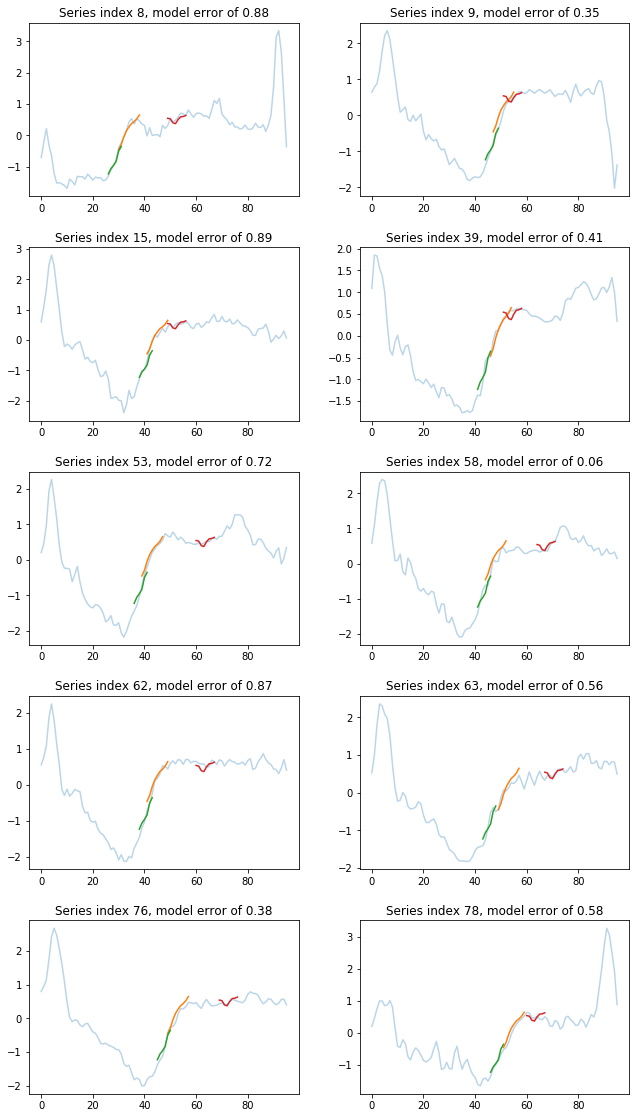

In [20]:
gendis.plot_series_and_shapelets(
    X=X,
    y=y,
    shapelets=shapelets,
    indexes_to_plot=sg_indexes,
)

<module 'matplotlib.pyplot' from '/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/matplotlib/pyplot.py'>

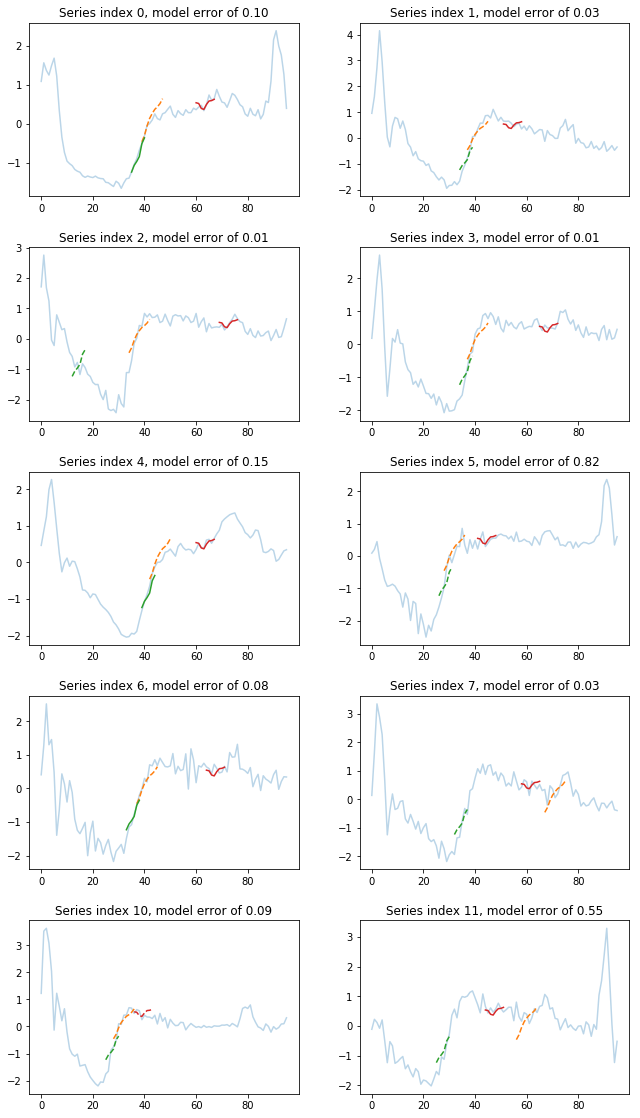

In [21]:
gendis.plot_series_and_shapelets(
    X=X,
    y=y,
    shapelets=shapelets,
    indexes_to_plot=not_sg_indexes,
)